# Imports

In [1]:
!git clone https://github.com/ultralytics/yolov5  
!pip install -U -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 14992, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 14992 (delta 0), reused 1 (delta 0), pack-reused 14989
Receiving objects: 100% (14992/14992), 14.01 MiB | 10.18 MiB/s, done.
Resolving deltas: 100% (10302/10302), done.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.8/775.8 kB 115.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 145.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 126.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 66.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 152.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 74.0 MB/s

In [1]:
import os
import glob
import pandas as pd
import shutil
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torch
#from utils.utils import plot_results

# Split data : train / val / test

In [2]:
train_df = pd.read_csv('./raw/train.csv')
test_df = pd.read_csv('./raw/test.csv')


############# SAMPLE ##################################################
# train_df = pd.concat([train_df[train_df['class'] == 0].head(50) , train_df[train_df['class'] == 1].head(50) ,
#                      train_df[train_df['class'] == 2].head(50) , train_df[train_df['class'] == 3].head(50) ,
#                      train_df[train_df['class'] == 4].head(50) , train_df[train_df['class'] == 5].head(50),
#                     train_df[train_df['class'] == 6].head(50) ,
#                     train_df[train_df['class'] == 7].head(50) , train_df[train_df['class'] == 8].head(50) ,
#                      train_df[train_df['class'] == 9].head(50) , train_df[train_df['class'] == 10].head(50)
#                      ])

# test_df = test_df[:200]
##########################################################################
 


images_dir = './raw/images'
train_dir = './dataset/train/images'
val_dir = './dataset/val/images'
test_dir = './dataset/test/images'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

os.mkdir(train_dir)

for image in train_df.image_path.unique():
    shutil.copyfile(os.path.join(images_dir, image), os.path.join(train_dir, image))
    

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.mkdir(test_dir)

for image in test_df.image_path.unique():
    shutil.copyfile(os.path.join(images_dir, image), os.path.join(test_dir, image))

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(val_dir)

train_images = os.listdir(train_dir)
val_images = train_images[len(train_images) - int(len(train_images) * 0.33) : ]
for image in val_images:
    shutil.move(os.path.join(train_dir, image), os.path.join(val_dir, image))

val_df = train_df[train_df.image_path.isin(val_images)]
train_df = train_df[~train_df.image_path.isin(val_images)]

val_df = val_df.reset_index()
train_df = train_df.reset_index()

del val_df['index']
del train_df['index']


# Get classes

In [3]:
classes = train_df.drop_duplicates('name').sort_values(by='class').reset_index()
classes = classes[['name', 'class']]
classes

,name,class
0,GRAFFITI,0.0
1,FADED_SIGNAGE,1.0
2,POTHOLES,2.0
3,GARBAGE,3.0
4,CONSTRUCTION_ROAD,4.0
5,BROKEN_SIGNAGE,5.0
6,BAD_STREETLIGHT,6.0
7,BAD_BILLBOARD,7.0
8,SAND_ON_ROAD,8.0
9,CLUTTER_SIDEWALK,9.0


In [4]:
classes_context = '['
for c in classes['name'].values:
    classes_context =  classes_context +  "'" + c + "', "
classes_context = classes_context[:-2]
classes_context = classes_context + ']'
classes_context

"['GRAFFITI', 'FADED_SIGNAGE', 'POTHOLES', 'GARBAGE', 'CONSTRUCTION_ROAD', 'BROKEN_SIGNAGE', 'BAD_STREETLIGHT', 'BAD_BILLBOARD', 'SAND_ON_ROAD', 'CLUTTER_SIDEWALK', 'UNKEPT_FACADE']"

# Convert dimensions

In [5]:
def convert_dimensions(path=train_dir, df=train_df):
    xs = [] 
    ys = [] 
    ws = [] 
    hs = []
    heights = []
    widths = []
    
    df = df.reset_index()
    for i in df.index:
        image = Image.open(os.path.join(path,df.iloc[i].image_path))
        height = image.height
        width = image.width
        
        xmax = df.iloc[i].xmax #* 2
        xmin = df.iloc[i].xmin #* 2
        ymax = df.iloc[i].ymax #* 2
        ymin = df.iloc[i].ymin #* 2
        
        x = ((xmax + xmin) / (2 * width))
        y = ((ymax + ymin) / (2 * height))
        w = (xmax - xmin) / width
        h = (ymax - ymin) / height
        
        xs.append(x)
        ys.append(y)
        ws.append(w)
        hs.append(h)
        
        heights.append(height)
        widths.append(width)
    
    return (xs, ys, ws, hs, widths, heights)

In [6]:
#train_df = pd.read_csv('./raw/train.csv')
train_df.ymin = train_df.ymin * 2
train_df.ymax = train_df.ymax * 2
train_df.xmin = train_df.xmin * 2
train_df.xmax = train_df.xmax * 2
new_training_dimensions = convert_dimensions()

In [7]:
train_df['x'] = new_training_dimensions[0]
train_df['y'] = new_training_dimensions[1]
train_df['w'] = new_training_dimensions[2]
train_df['h'] = new_training_dimensions[3]

train_df['width'] = new_training_dimensions[4]
train_df['height'] = new_training_dimensions[5]

In [8]:
train_df.head()

,class,image_path,name,xmax,xmin,ymax,ymin,x,y,w,h,width,height
0,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1594.0,1402.0,524.0,422.0,0.780208,0.437963,0.100000,0.094444,1920,1080
1,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1864.0,1572.0,658.0,476.0,0.894792,0.525000,0.152083,0.168519,1920,1080
2,3.0,4a48c42c9579ec0399e6c5a3e825e765.jpg,GARBAGE,1472.0,1314.0,550.0,458.0,0.725521,0.466667,0.082292,0.085185,1920,1080
3,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,1334.0,1098.0,456.0,358.0,0.633333,0.376852,0.122917,0.090741,1920,1080
4,8.0,1c7d48005a12d1b19261b8e71df7cafe.jpg,SAND_ON_ROAD,1598.0,1256.0,476.0,352.0,0.743229,0.383333,0.178125,0.114815,1920,1080


In [9]:
train_df.shape

(13305, 13)

In [10]:
val_df.ymin = val_df.ymin * 2
val_df.ymax = val_df.ymax * 2
val_df.xmin = val_df.xmin * 2
val_df.xmax = val_df.xmax * 2
new_val_dimensions = convert_dimensions(path=val_dir, df=val_df)

In [11]:
val_df['x'] = new_val_dimensions[0]
val_df['y'] = new_val_dimensions[1]
val_df['w'] = new_val_dimensions[2]
val_df['h'] = new_val_dimensions[3]

val_df['width'] = new_val_dimensions[4]
val_df['height'] = new_val_dimensions[5]

In [12]:
val_df.head()

,class,image_path,name,xmax,xmin,ymax,ymin,x,y,w,h,width,height
0,7.0,ea906a663da6321bcef78be4b7d1afff.jpg,BAD_BILLBOARD,1972.0,1572.0,272.0,0.0,0.922917,0.125926,0.208333,0.251852,1920,1080
1,2.0,e1f3026bc4b1689d81f03e92e9043c2b.jpg,POTHOLES,1682.0,1280.0,816.0,568.0,0.771354,0.640741,0.209375,0.229630,1920,1080
2,3.0,c12b006174423ceb3e2e3563a8ca7751.jpg,GARBAGE,1196.0,936.0,1114.0,974.0,0.555208,0.966667,0.135417,0.129630,1920,1080
3,3.0,f05cd6411a3509a5ddc9d9a52536df01.jpg,GARBAGE,1848.0,1628.0,532.0,360.0,0.905208,0.412963,0.114583,0.159259,1920,1080
4,2.0,f05cd6411a3509a5ddc9d9a52536df01.jpg,POTHOLES,734.0,396.0,598.0,480.0,0.294271,0.499074,0.176042,0.109259,1920,1080


# Object detection (random)

In [13]:
def object_detection_random(df=train_df, path=train_dir, count=1):
    counter = 0 
    #df = df[df.image_path=='443a50c860568eb0e6188525400f1736.jpg']
    df = df.sample(frac=1)
    for image_path in df.image_path.unique():
        select_df = df[df.image_path == image_path].reset_index()
        del select_df['index']
        
        image = cv2.cvtColor(cv2.imread(os.path.join(path, image_path)), cv2.COLOR_BGR2RGB)
        for i in select_df.index:
            xmin = select_df.iloc[i].xmin #* 2
            ymin = select_df.iloc[i].ymin #* 2
            xmax = select_df.iloc[i].xmax #* 2
            ymax = select_df.iloc[i].ymax #* 2
            height = select_df.iloc[i].height
            width = select_df.iloc[i].width
            label = select_df.iloc[i]['name']
            
            print('class:' , select_df.iloc[i]['name'])
            print('xmin:' , xmin)
            print('ymin:' , ymin)
            print('xmax:' , xmax)
            print('ymax:' , ymax)
            print('----------------------------')
            
            cv2.rectangle(image,
                          (int(xmin) , int(ymin) ),
                          (int(xmax) , int(ymax) ),
                          (0,255,0), thickness=2)
            
            ((label_width, label_height), _) = cv2.getTextSize(label, fontFace=cv2.FONT_HERSHEY_PLAIN, 
            fontScale=1.75, thickness=2)
            
            cv2.rectangle(
      image,
          (int(xmin) , int(ymin)),
          (int(xmin + label_width + label_width * 0.05), int(ymin + label_height + label_height * 0.25)),
          color=(255, 0, 0),
          thickness=cv2.FILLED
        )
            
            cv2.putText(
          image,
          label,
          org=(int(xmin), int(ymin + label_height + label_height * 0.25)), 
          fontFace=cv2.FONT_HERSHEY_PLAIN,
          fontScale=1.75,
          color=(255, 255, 255),
          thickness=2 )
            
            plt.imshow(image)
        
        counter = counter + 1
        if count != None and count > 0 and counter >= count:
            break
            


class: BAD_BILLBOARD
xmin: -6.0
ymin: 12.0
xmax: 716.0
ymax: 398.0
----------------------------


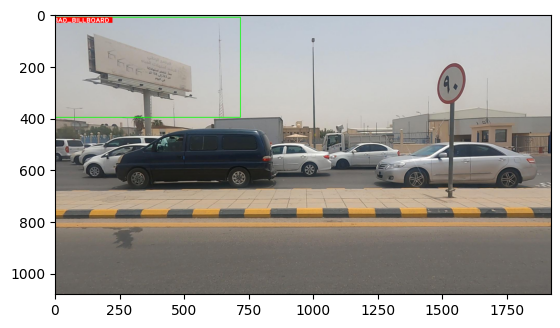

In [14]:
object_detection_random()

class: GARBAGE
xmin: 642.0
ymin: 438.0
xmax: 902.0
ymax: 628.0
----------------------------
class: GARBAGE
xmin: 844.0
ymin: 494.0
xmax: 1036.0
ymax: 636.0
----------------------------
class: GARBAGE
xmin: 1288.0
ymin: 512.0
xmax: 1472.0
ymax: 642.0
----------------------------
class: GARBAGE
xmin: 988.0
ymin: 512.0
xmax: 1210.0
ymax: 684.0
----------------------------
class: GARBAGE
xmin: 1524.0
ymin: 520.0
xmax: 1796.0
ymax: 686.0
----------------------------
class: GARBAGE
xmin: 496.0
ymin: 432.0
xmax: 714.0
ymax: 600.0
----------------------------


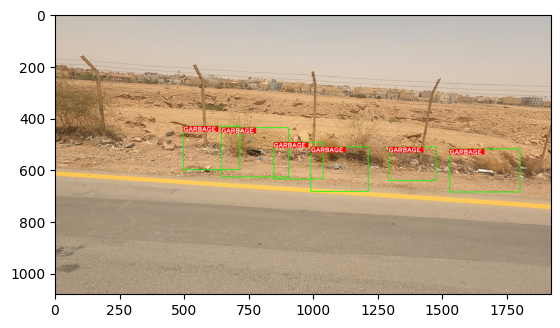

In [15]:
object_detection_random(df=val_df, path=val_dir, count=1)

# Label files

In [16]:
def create_labels(df=train_df, path='./dataset/train/labels'):
    
    if os.path.exists(path):
        shutil.rmtree(path)
        
    os.mkdir(path)
    
    df = df.reset_index()
    for i in df.index:
        _class = df.iloc[i]['class']
        file_name = df.iloc[i].image_path.split('.')[0] + '.txt'
        x = df.iloc[i].x
        y = df.iloc[i].y
        w = df.iloc[i].w
        h = df.iloc[i].h
        
        content = '{} {} {} {} {}\n'
        content = content.format(_class, x, y, w, h)
        
        f = open(os.path.join(path, file_name) , 'a')
        f.write(content)
        f.close()

In [17]:
create_labels()

In [18]:
create_labels(val_df, './dataset/val/labels')

# Create config files

In [19]:
dataset_config_text = """train: {}
val : {}
nc: {}
names: {}
"""

dataset_config_text = dataset_config_text.format('../' + train_dir, '../' + val_dir, classes['name'].nunique(), classes_context)

f = open('./yolov5/dataset_config.yaml', 'w')
f.write(dataset_config_text)
f.close()


In [20]:
model_config_text = """# parameters
nc: {}  # number of classes  # CHANGED HERE
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]
"""

model_config_text = model_config_text.format(classes['name'].nunique())

f = open('./yolov5/model_config.yaml', 'w')
f.write(model_config_text)
f.close()

# Train model

In [23]:
!python yolov5/train.py --img 768  --epochs 50 --data yolov5/dataset_config.yaml --weights yolov5/yolov5x.pt --cache --workers 16

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
train: weights=yolov5/yolov5x.pt, cfg=, data=yolov5/dataset_config.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=768, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=16, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-70-g589edc7 Python-3.8.10 torch-1.13.1+c

# Detection

In [ ]:
#!python yolov5/detect.py --weights yolov5/runs/train/exp2/weights/best.pt --img 640 --conf 0.4 --source dataset/test/images

In [26]:
weight_path = './yolov5/runs/train/exp/weights/best.pt'
model = torch.hub.load('yolov5', 'custom', path=weight_path, source='local')
model.conf = 0.7
final_output = pd.DataFrame()

for image in test_df.image_path:
    results = model(os.path.join(test_dir,image))
    output = results.pandas().xyxy[0]
    output['image_path'] = image
    final_output = pd.concat([final_output, output])

final_output.to_csv('./outputs/results_conf.csv', index=False, encoding='utf-8-sig')
# final_output = final_output[['class','image_path','name','xmax','xmin','ymax','ymin']]
# final_output.to_csv('./outputs/final_output_2.csv', index=False, encoding='utf-8-sig')

YOLOv5  v7.0-63-gcdd804d Python-3.9.13 torch-1.13.1+cpu CPU

Fusing layers... 
Model summary: 322 layers, 86240704 parameters, 0 gradients, 204.0 GFLOPs
Adding AutoShape... 


# Detect with low conf

In [27]:
final_output = pd.read_csv('./outputs/results_conf.csv')
print('Results pics:', str(final_output.image_path.nunique()), final_output.shape )
print('Testset pics:', str(test_df.image_path.nunique()) )

Results pics: 776 (1064, 8)
Testset pics: 2092


In [29]:
not_predict_pics = test_df[~test_df.image_path.isin(final_output.image_path.unique())]
val_output = pd.DataFrame()

model.conf = 0.01
model.iou = 0.2


for image in not_predict_pics.image_path:
    results = model(os.path.join(test_dir,image))
    output = results.pandas().xyxy[0]
    output['image_path'] = image
    val_output = pd.concat([val_output, output])

In [30]:
val_output.image_path.nunique()

1316

In [31]:
val_output.shape

(9623, 8)

In [32]:
val_output = pd.concat([val_output, final_output])

val_output.xmax = val_output.xmax.astype(int)
val_output.xmin = val_output.xmin.astype(int)
val_output.ymax = val_output.ymax.astype(int)
val_output.ymin = val_output.ymin.astype(int)

val_output.to_csv('./outputs/val_final_conf.csv', index=False, encoding='utf-8-sig')
val_output = val_output[['class','image_path','name','xmax','xmin','ymax','ymin']]
val_output.to_csv('./outputs/final_results_vv2.csv', index=False, encoding='utf-8-sig')

In [33]:
val_output.shape

(10687, 7)

# Detect objects from final results

In [38]:
def object_detection(df=val_output, path=test_dir, change_width=False, image_path=False):
    
    if image_path != False:
        select_df = df[df.image_path == image_path].reset_index()
    else:
        df = df.sample(frac=1)
        image_path = df.iloc[0].image_path
        select_df = df[df.image_path == image_path].reset_index()
        
    print(image_path)
    image = cv2.cvtColor(cv2.imread(os.path.join(path, image_path)), cv2.COLOR_BGR2RGB)
    for i in select_df.index:
        xmin = select_df.iloc[i].xmin #* 2
        ymin = select_df.iloc[i].ymin #* 2
        xmax = select_df.iloc[i].xmax #* 2
        ymax = select_df.iloc[i].ymax #* 2
        label = select_df.iloc[i]['name']
        
        height = image.shape[0]
        width = image.shape[1]
        if change_width == True:
            width = 960
            image = cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA)
            xmax = xmax / 2
            xmin = xmin / 2

        print('class:' , select_df.iloc[i]['name'])
        print('xmin:' , xmin)
        print('ymin:' , ymin)
        print('xmax:' , xmax)
        print('ymax:' , ymax)
        print('----------------------------')
            
        cv2.rectangle(image,
                      (int(xmin) , int(ymin) ),
                      (int(xmax) , int(ymax) ),
                      (0,255,0), thickness=2)

        ((label_width, label_height), _) = cv2.getTextSize(label, fontFace=cv2.FONT_HERSHEY_PLAIN, 
        fontScale=1.75, thickness=2)

        cv2.rectangle(
      image,
      (int(xmin) , int(ymin)),
      (int(xmin + label_width + label_width * 0.05), int(ymin + label_height + label_height * 0.25)),
      color=(255, 0, 0),
      thickness=cv2.FILLED
    )

        cv2.putText(
      image,
      label,
      org=(int(xmin), int(ymin + label_height + label_height * 0.25)), 
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2 )

    plt.imshow(image)
    plt.show()

            
